# Convert the Radar Data Format to Row-Wise Format


In [1]:
import os
import sys
from pathlib import Path


def recursive_root(path: str, find="sumo-uc-2023"):
    if os.path.split(path)[-1] == find:
        return Path(path)
    return recursive_root(os.path.split(path)[0], find=find)


ROOT = recursive_root(os.path.abspath("."))
sys.path.append(str(ROOT))


In [2]:
import pandas as pd
import numpy as np


## Read in the data


In [3]:
DATA_DIR = ROOT / "data" / "2023-01-13"

pwlf_data = pd.read_parquet(DATA_DIR / "pwlf_method.parquet")
lowess_data = pd.read_parquet(DATA_DIR / "lowess_method.parquet")
headway_data = pd.read_parquet(DATA_DIR / "headway.parquet")
headway_data.set_index("veh", inplace=True)
headway_data = headway_data[headway_data["mean"] > 0.20]


vehicle_length_table = pd.read_parquet(DATA_DIR / "car_lengths.parquet")
# only keep lengths that are greater than 2m
vehicle_length_table = vehicle_length_table[vehicle_length_table["f32_length_m"] >= 2.0]


In [4]:
vehicle_length_table.head()


,ui32_objectID,f32_length_m
0,35256,3.327021
1,35257,8.543118
2,35258,4.468826
3,35259,4.739034
4,35260,3.769435


### Label the Operation Modes


In [5]:
# pwlf_data['method'] = 'pwlf'
# lowess_data['method'] = 'lowess'
# data = pd.concat([pwlf_data, lowess_data], axis=0)


In [6]:
cruise_thresh = 0.1

pwlf_data["type"] = np.where(pwlf_data["accel"] > cruise_thresh, "accel", "")
pwlf_data["type"] = np.where(
    pwlf_data["accel"] < -cruise_thresh, "decel", pwlf_data["type"]
)
pwlf_data["type"] = np.where(
    pwlf_data["accel"].abs() <= cruise_thresh, "cruise", pwlf_data["type"]
)


In [7]:
import itertools

accels = []
res = []
for r2, minium_time_in_state in itertools.product(
    np.linspace(0.75, 0.99, 10), np.linspace(0, 4, 10)
):
    base_filter = (pwlf_data["time_diff"] > minium_time_in_state) & (
        pwlf_data["r2"] > r2
    )

    pwlf_data_accel = (
        pwlf_data[(pwlf_data["type"] == "accel") & base_filter]
        .groupby("vehicle_id")
        .apply(lambda x: np.average(x["accel"], weights=x["time_diff"]))
    )
    pwlf_data_decel = (
        pwlf_data[(pwlf_data["type"] == "decel") & base_filter]
        .groupby("vehicle_id")
        .apply(lambda x: np.average(x["accel"], weights=x["time_diff"]))
    )

    res.append(
        (
            r2,
            minium_time_in_state,
            pwlf_data_accel.median(),
            pwlf_data_decel.median(),
            pwlf_data_accel.shape[0],
            pwlf_data_decel.shape[0],
        )
    )


df = pd.DataFrame(
    res, columns=["r2", "min_time", "accel", "decel", "num_accel", "num_decel"]
)


Text(0.5, 0, 'Deceleration [$m/s^2$]')

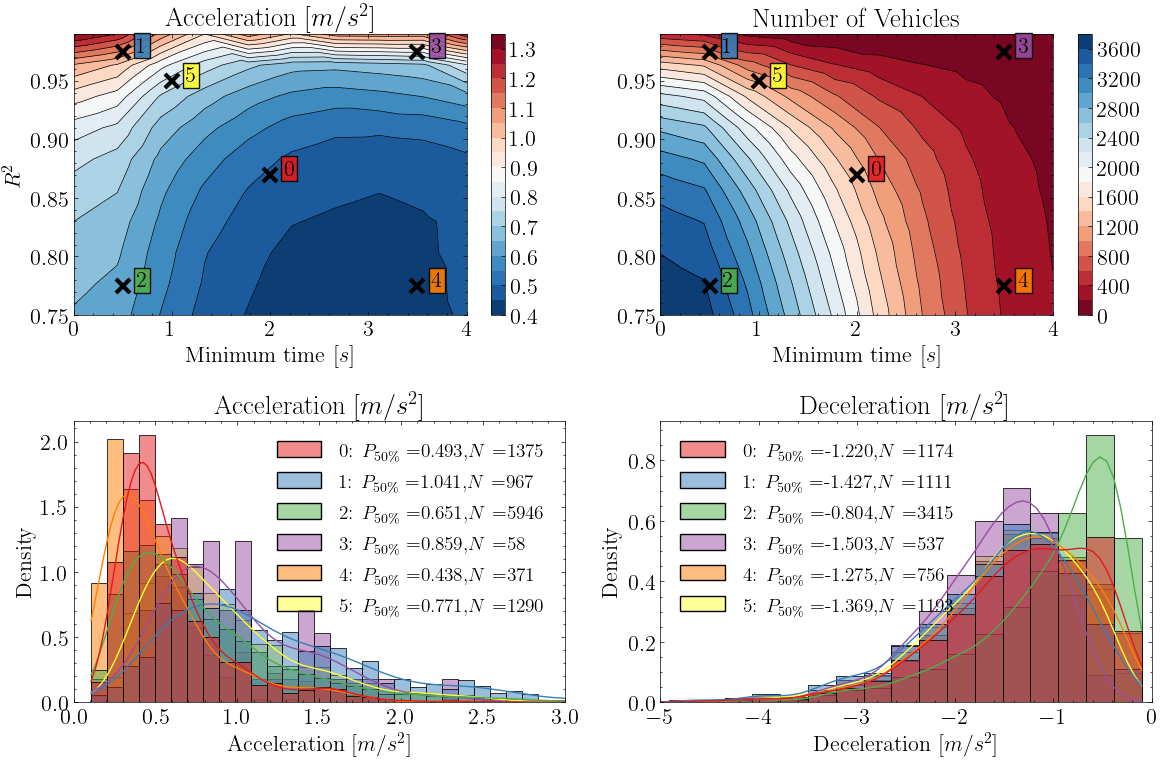

In [8]:
import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("science")
# update the font size
plt.rcParams.update({"font.size": 16})
# create a color palette
palette = plt.get_cmap("Set1")
# create a map of colors for each group
color_map = {
    f"{i}": palette(i)
    for i in range(6)
}

fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharey=False, tight_layout=True)

# plot locations
xys = [
    df[["min_time", "r2"]].values.mean(axis=0),
    [.5, 0.975],
    [.5, .775],
    [3.5, 0.975],
    [3.5, .775],
    [1, 0.95]
]


x = df["min_time"].values.tolist()
y = df["r2"].values.tolist()
z = df["accel"].values.tolist()
ax[0, 0].tricontour(x, y, z, levels=20, linewidths=0.5, colors="k")
cntr1 = ax[0, 0].tricontourf(x, y, z, levels=20, cmap="RdBu_r")
fig.colorbar(cntr1, ax=ax[0, 0])
ax[0, 0].set_title("Acceleration [$m/s^2$]")
ax[0, 0].set_ylabel("$R^2$")
ax[0, 0].set_xlabel("Minimum time [$s$]")

# add an X to the mean
for i, (_x, _y) in enumerate(xys):
    for j in range(2):    
        ax[0, j].plot(
            _x,
            _y,
            "x",
            color="black",
            markersize=10,
            markeredgewidth=3,
        )
        ax[0, j].annotate(
            f"{i}",
            (_x, _y),
            # add a white background to the text
            bbox=dict(facecolor=color_map[str(i)], edgecolor="black", pad=2, alpha=0.9),
            # move the text to the right
            xytext=(10, 0),
            textcoords="offset points",
        )


z = df["num_accel"].values.tolist()
ax[0, 1].tricontour(x, y, z, levels=20, linewidths=0.5, colors="k")
cntr1 = ax[0, 1].tricontourf(x, y, z, levels=20, cmap="RdBu")
fig.colorbar(cntr1, ax=ax[0, 1])
ax[0, 1].set_title("Number of Vehicles")
ax[0, 1].set_xlabel("Minimum time [$s$]")

# add distributions to 1, 0
for j, type_ in enumerate(["accel", "decel"]):

    dists = []
    for i, (_x, _y) in enumerate(xys):
        base_filter = (pwlf_data["time_diff"] > _x) & (
            pwlf_data["r2"] > _y
        )

        _df =  pd.DataFrame(
            # pwlf_data[(pwlf_data["type"] == type_) & base_filter].groupby("vehicle_id").apply(lambda x: np.average(x["accel"], weights=x["time_diff"])).values,
            pwlf_data.loc[(pwlf_data["type"] == type_) & base_filter, 'accel'].values,
            columns=[type_],
        )
        _df['sample_pair'] = f"{i}"
        dists.append(_df)
        

    dist_df = pd.concat(dists)
    sns.histplot(
        data=dist_df,
        x=type_,
        bins=50,
        ax=ax[1, j],
        stat="density",
        common_norm=False,
        kde=True,
        hue="sample_pair",
        palette=color_map,
    )
    # set the range of the x axis
    

    # # remove the legend title
    ax[1, j].legend_.set_title(None)
    # set the background color of the legend
    ax[1, j].legend_.get_frame().set_facecolor("white")



    for t in ax[1, j].legend_.texts: 
        l = t.get_text()
        t.set_text(
            f"{l}" + ": $P_{50\%} = $" + f"{dist_df.loc[dist_df['sample_pair'] == l, type_].median():.3f},$N=${dist_df.loc[dist_df['sample_pair'] == l, type_].shape[0]}"
        )
        # set the text size
        t.set_fontsize(14)
    
ax[1, 0].set_xlim(0, 3)
ax[1, 0].set_title("Acceleration [$m/s^2$]")
ax[1, 0].set_xlabel("Acceleration [$m/s^2$]")

ax[1, 1].set_xlim(-5, 0)
ax[1, 1].set_title("Deceleration [$m/s^2$]")
ax[1, 1].set_xlabel("Deceleration [$m/s^2$]")


In [9]:
minium_time_in_state = 1
r2 = 0.95

base_filter = (pwlf_data["time_diff"] > minium_time_in_state) & (
        pwlf_data["r2"] > r2
    )
pwlf_data_accel = (
    pwlf_data[(pwlf_data["type"] == "accel") & base_filter]
    .groupby("vehicle_id")
    .apply(lambda x: np.average(x["accel"], weights=x["time_diff"]))
)
pwlf_data_decel = (
    pwlf_data[(pwlf_data["type"] == "decel") & base_filter]
    .groupby("vehicle_id")
    .apply(lambda x: np.average(x["accel"], weights=x["time_diff"]))
)

minium_time_in_state = 0.1
pwlf_data_cruise = (
    pwlf_data[
        (pwlf_data["type"] == "cruise")
        & (pwlf_data["time_diff"] > minium_time_in_state)
    ]
    .groupby("vehicle_id")
    .apply(lambda x: np.average(x["speed"], weights=x["time_diff"]))
)

In [10]:
cruise_thresh = 0.1
lowess_data["type"] = np.where(lowess_data["accel"] > cruise_thresh, "accel", "")
lowess_data["type"] = np.where(
    lowess_data["accel"] < -cruise_thresh, "decel", lowess_data["type"]
)
lowess_data["type"] = np.where(
    lowess_data["accel"].abs() <= cruise_thresh, "cruise", lowess_data["type"]
)


In [11]:
minium_time_in_state = 1.5
base_filter = lowess_data["time_diff"] > minium_time_in_state
lowess_accel = (
    lowess_data[(lowess_data["type"] == "accel") & base_filter]
    .groupby("vehicle_id")
    .apply(lambda x: np.average(x["accel"], weights=x["time_diff"]))
)
lowess_decel = (
    lowess_data[(lowess_data["type"] == "decel") & base_filter]
    .groupby("vehicle_id")
    .apply(lambda x: np.average(x["accel"], weights=x["time_diff"]))
)


minium_time_in_state = 0.1
base_filter = lowess_data["time_diff"] > minium_time_in_state
lowess_cruise = (
    lowess_data[(lowess_data["type"] == "cruise") & base_filter]
    .groupby("vehicle_id")
    .apply(lambda x: np.average(x["speed"], weights=x["time_diff"]))
)


### Plotting


In [12]:
def hist_ecdf(*plots, ax, colors, limits):
    for i, plot_series in enumerate(plots):
        ax.hist(
            plot_series[1],
            bins=100,
            label=plot_series[0],
            alpha=0.5,
            density=True,
            color=colors[i],
        )

        # create a ecdf of the acceleration values on the right y-axis
        ax2 = ax.twinx()
        ax2.scatter(
            np.sort(plot_series[1].values),
            np.linspace(0, 1, len(plot_series[1].values)),
            label=plot_series[0],
            alpha=1,
            s=1,
            color=colors[i],
        )

    # set x-axis limits
    ax.set_xlim(*limits)


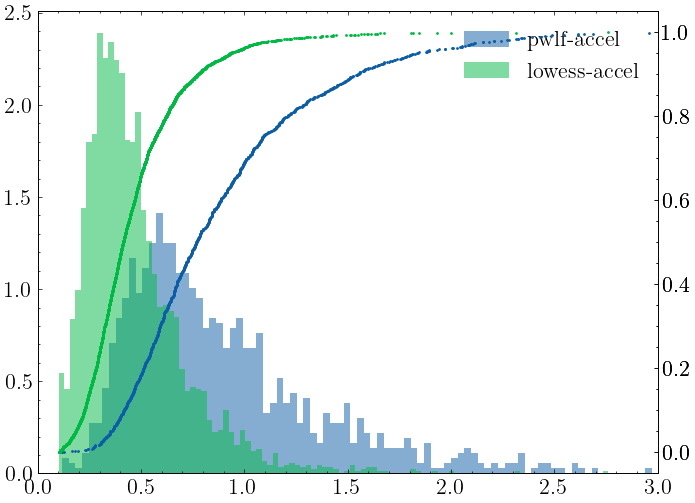

In [13]:
import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("science")
plt.rcParams.update({"font.size": 16})

# create a color palette
palette = colors = sns.color_palette("Paired", 8, desat=0.8)
# get every other color
colors = [palette[i] for i in range(0, len(palette), 2)]

# plot pwlf accel vs decel
fig, ax = plt.subplots(figsize=(8, 6))
hist_ecdf(
    ("pwlf-accel", pwlf_data_accel),
    ("lowess-accel", lowess_accel),
    ax=ax,
    colors=["C0", "C1"],
    limits=(0, 3),
)

ax.legend()


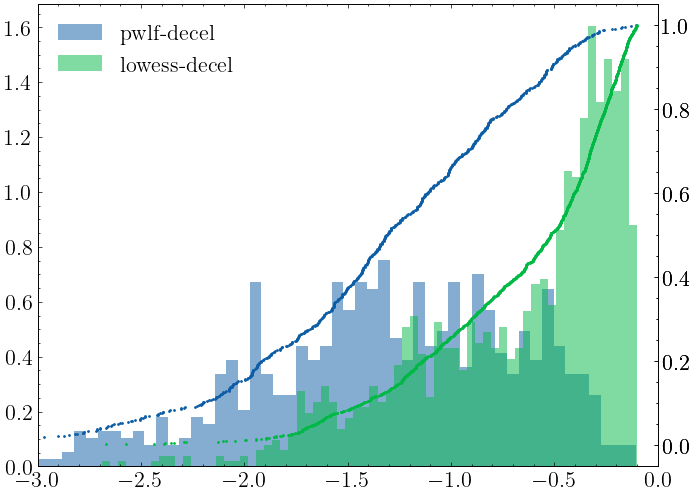

In [14]:
import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("science")
plt.rcParams.update({"font.size": 16})

# create a color palette
palette = colors = sns.color_palette("Paired", 8, desat=0.8)
# get every other color
colors = [palette[i] for i in range(0, len(palette), 2)]

# plot pwlf accel vs decel
fig, ax = plt.subplots(figsize=(8, 6))
hist_ecdf(
    ("pwlf-decel", pwlf_data_decel),
    ("lowess-decel", lowess_decel),
    ax=ax,
    colors=["C0", "C1"],
    limits=(-3, 0),
)

ax.legend()


### Additional Cruise Filtering


In [15]:
filter_ = lowess_cruise.index.isin(headway_data[headway_data["mean"] > 5].index) & (
    lowess_data.loc[lowess_data.vehicle_id.isin(lowess_cruise.index)]
    .groupby("vehicle_id")["accel"]
    .max()
    .loc[lowess_cruise.index]
    .abs()
    < 1
)
lowess_cruise_new = lowess_cruise[filter_]

# do the same for pwlf
filter_ = pwlf_data_cruise.index.isin(headway_data[headway_data["mean"] > 5].index) & (
    pwlf_data.loc[pwlf_data.vehicle_id.isin(pwlf_data_cruise.index)]
    .groupby("vehicle_id")["accel"]
    .max()
    .loc[pwlf_data_cruise.index]
    .abs()
    < 1
)
pwlf_data_cruise_new = pwlf_data_cruise[filter_]


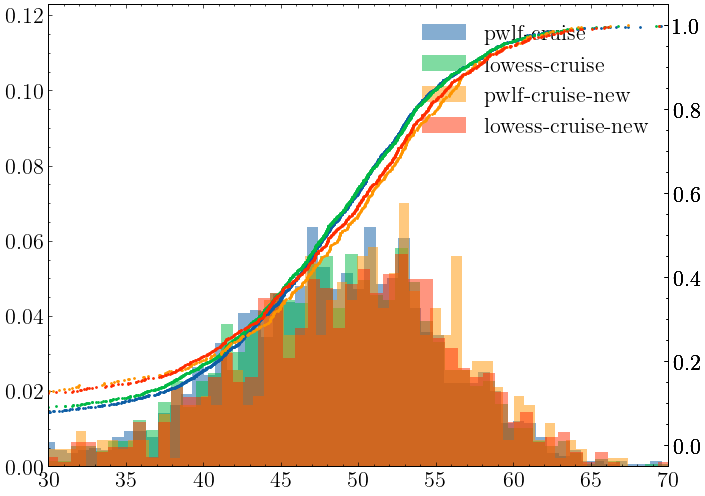

In [16]:
# plot pwlf accel vs decel
fig, ax = plt.subplots(figsize=(8, 6))
hist_ecdf(
    ("pwlf-cruise", pwlf_data_cruise * 2.23694),
    ("lowess-cruise", lowess_cruise * 2.23694),
    ("pwlf-cruise-new", pwlf_data_cruise_new * 2.23694),
    ("lowess-cruise-new", lowess_cruise_new * 2.23694),
    ax=ax,
    colors=["C0", "C1", "C2", "C3"],
    limits=(30, 70),
)

ax.legend()


In [17]:
# create the speed factors
speed_limit = 22.35

# create the speed factors
pwlf_data_cruise_new = pwlf_data_cruise_new / speed_limit
lowess_cruise_new = lowess_cruise_new / speed_limit

# filter out low end. Nothing slower than 35 mph
filter_ = pwlf_data_cruise_new > (35 / (speed_limit * 2.23694))
pwlf_data_cruise_new = pwlf_data_cruise_new[filter_]

filter_ = lowess_cruise_new > (35 / (speed_limit * 2.23694))
lowess_cruise_new = lowess_cruise_new[filter_]


### Create a DataFrame for SUMO


In [18]:
# only keep headway data where the vehicle has headway < 5
merge_headway = headway_data[headway_data["mean"] < 5]


In [48]:
lowess_df = lowess_accel.to_frame("accel").merge(
    lowess_decel.to_frame("decel"), left_index=True, right_index=True, how="inner"
)
corr_lowess_df = lowess_df.merge(
    merge_headway.rename({"mean": "tau"}, axis=1),
    left_index=True,
    right_index=True,
    how="inner",
)
corr_lowess_df["decel"] = corr_lowess_df["decel"] * -1
corr_lowess_df = (
    corr_lowess_df.merge(
        vehicle_length_table, left_index=True, right_on="ui32_objectID", how="inner"
    )
    .rename({"f32_length_m": "length"}, axis=1)
    .drop(["ui32_objectID"], axis=1)
)

In [52]:
corr_lowess_df["speedFactor"] = np.random.choice(
    lowess_cruise_new, size=corr_lowess_df.shape[0]
)


In [53]:
corr_lowess_df.corr()


,accel,decel,tau,length,speedFactor
accel,1.000000,0.147247,-0.040025,0.364620,0.025233
decel,0.147247,1.000000,0.238568,0.151367,-0.058123
tau,-0.040025,0.238568,1.000000,0.041750,-0.018232
length,0.364620,0.151367,0.041750,1.000000,-0.032098
speedFactor,0.025233,-0.058123,-0.018232,-0.032098,1.000000


In [54]:
samples = 10000

np.random.seed(42)

# create a random sample of the data
uncor_lowess_df = pd.DataFrame(
    {
        "accel": np.random.choice(lowess_accel, samples),
        "decel": np.random.choice(lowess_decel, samples),
        "tau": np.random.choice(merge_headway["mean"], samples),
        "length": np.random.choice(vehicle_length_table["f32_length_m"], samples),
        "speedFactor": np.random.choice(lowess_cruise_new, samples),
    }
)


In [55]:
print(pwlf_data_accel.shape, pwlf_data_decel.shape)
pwlf_df = pwlf_data_accel.to_frame("accel").merge(
    pwlf_data_decel.to_frame("decel"), left_index=True, right_index=True, how="inner"
)
print(pwlf_df.shape)
corr_pwlf_df = pwlf_df.merge(
    merge_headway.rename({"mean": "tau"}, axis=1),
    left_index=True,
    right_index=True,
    how="inner",
)
print(corr_pwlf_df.shape)
corr_pwlf_df["decel"] = corr_pwlf_df["decel"] * -1
corr_pwlf_df = (
    corr_pwlf_df.merge(
        vehicle_length_table, left_index=True, right_on="ui32_objectID", how="inner"
    )
    .rename({"f32_length_m": "length"}, axis=1)
    .drop(["ui32_objectID"], axis=1)
)
print(corr_pwlf_df.shape)
corr_pwlf_df["speedFactor"] = np.random.choice(
    pwlf_data_cruise_new, size=corr_pwlf_df.shape[0]
)


(1135,) (682,)
(165, 2)
(48, 3)
(48, 4)


In [57]:
# create an product sample
# get the ids that are in both
minium_time_in_state = 1
r2 = 0.95

pwlf_data = pwlf_data.loc[
    (pwlf_data.time_diff > minium_time_in_state)
    & (pwlf_data.r2 > r2)
    & pwlf_data.type.isin(['accel', 'decel'])
]

# keep vehicles that have both accel and decel
pwlf_data_keep = pwlf_data.groupby("vehicle_id").filter(
    lambda x: x.type.nunique() == 2
)

res = []
for v_id, v_df in pwlf_data_keep.groupby("vehicle_id"):
    accels = v_df[v_df.type == "accel"].accel.values
    decels = v_df[v_df.type == "decel"].accel.values
    for accel in accels:
        res.extend(
            {"vehicle_id": v_id, "accel": accel, "decel": decel}
            for decel in decels
        )

In [46]:
res

[{'vehicle_id': 35415,
  'accel': 0.9362721403864536,
  'decel': -1.0295871171489717},
 {'vehicle_id': 35415,
  'accel': 0.4767067052108917,
  'decel': -1.0295871171489717},
 {'vehicle_id': 35420,
  'accel': 0.9936612657946547,
  'decel': -1.0271695148560787},
 {'vehicle_id': 35420,
  'accel': 0.7510555482007832,
  'decel': -1.0271695148560787},
 {'vehicle_id': 35580,
  'accel': 0.8898379778741092,
  'decel': -0.6770260854529627},
 {'vehicle_id': 35580,
  'accel': 0.8898379778741092,
  'decel': -1.1994758761107718},
 {'vehicle_id': 35815,
  'accel': 1.8169551534914525,
  'decel': -2.7488218386728063},
 {'vehicle_id': 35815,
  'accel': 1.8169551534914525,
  'decel': -1.2990426012119258},
 {'vehicle_id': 35817,
  'accel': 1.4255153604872666,
  'decel': -1.5605712303865384},
 {'vehicle_id': 35817,
  'accel': 1.4255153604872666,
  'decel': -2.3464338654257144},
 {'vehicle_id': 35989,
  'accel': 1.181831006504472,
  'decel': -1.9999704051841967},
 {'vehicle_id': 35989,
  'accel': 1.18183100

In [24]:
corr_pwlf_df.corr()


,accel,decel,tau,length,speedFactor
accel,1.000000,0.658170,0.349315,0.396643,-0.159796
decel,0.658170,1.000000,0.455140,0.327059,-0.372508
tau,0.349315,0.455140,1.000000,0.339816,-0.272528
length,0.396643,0.327059,0.339816,1.000000,-0.103912
speedFactor,-0.159796,-0.372508,-0.272528,-0.103912,1.000000


In [25]:
corr_pwlf_df.head()


,accel,decel,tau,length,speedFactor
561,1.425515,2.039264,3.480033,5.042850,0.903645
1540,1.465063,1.390606,3.435073,4.282409,1.147319
1541,1.544246,1.565646,4.316304,5.154908,0.883483
1549,1.835426,1.234528,2.590541,5.234429,1.084445
1564,1.181854,0.812942,1.885499,4.939848,1.168006


In [26]:
samples = 10000

np.random.seed(42)

# create a random sample of the data
uncor_pwlf_df = pd.DataFrame(
    {
        "accel": np.random.choice(pwlf_data_accel, samples),
        "decel": np.random.choice(pwlf_data_decel, samples),
        "tau": np.random.choice(merge_headway["mean"], samples),
        "length": np.random.choice(vehicle_length_table["f32_length_m"], samples),
        "speedFactor": np.random.choice(pwlf_data_cruise_new, samples),
    }
)


In [27]:
uncor_pwlf_df.corr()


,accel,decel,tau,length,speedFactor
accel,1.000000,-0.018414,0.002481,-0.013620,-0.000700
decel,-0.018414,1.000000,0.002859,0.017130,0.023692
tau,0.002481,0.002859,1.000000,0.002804,-0.003625
length,-0.013620,0.017130,0.002804,1.000000,-0.014910
speedFactor,-0.000700,0.023692,-0.003625,-0.014910,1.000000


<AxesSubplot: ylabel='Proportion'>

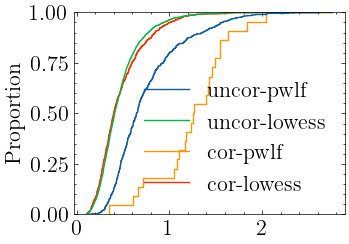

In [28]:
# create a dataframe with all the accel

sns.ecdfplot(
    pd.DataFrame(
        data=[
            uncor_pwlf_df["accel"].values,
            uncor_lowess_df["accel"].values,
            corr_pwlf_df["accel"].values,
            corr_lowess_df["accel"].values,
        ],
        index=[
            "uncor-pwlf",
            "uncor-lowess",
            "cor-pwlf",
            "cor-lowess",
        ],
    ).T
)


# sns.ecdfplot(

#     palette=["C0", "C1", "C2", "C3"],
#     # add the labels
#     labels=[
#         "uncor-pwlf",
#         "uncor-lowess",
#         "cor-pwlf",
#         "cor-lowess",
#     ],
# )


### Save the data


In [29]:
def save_df_to_csv(df, filename):
    df["vClass"] = "passenger"
    # this is dumb for now, but it works
    df["emissionClass"] = df["vClass"].map(
        {"passenger": "PHEMlight/PC_G_EU4", "trailer": "PHEMlight/HDV_TT_D_EU6"}
    )

    df["decel"] = df["decel"].abs()

    df.to_csv(filename, index=False)


In [30]:
save_df_to_csv(
    uncor_pwlf_df,
    "/Users/max/Development/sumo-uc-2023/data/2023-01-13/processed/uncor_pwlf.csv",
)
save_df_to_csv(
    uncor_lowess_df,
    "/Users/max/Development/sumo-uc-2023/data/2023-01-13/processed/uncor_lowess.csv",
)
save_df_to_csv(
    corr_pwlf_df,
    "/Users/max/Development/sumo-uc-2023/data/2023-01-13/processed/corr_pwlf.csv",
)
save_df_to_csv(
    corr_lowess_df,
    "/Users/max/Development/sumo-uc-2023/data/2023-01-13/processed/corr_lowess.csv",
)


## Plotting


In [55]:
import corner
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")

# make the text bigger
plt.rcParams.update({"font.size": 16})


In [58]:
corr_pwlf_df


,accel,decel,tau,length,vClass,emissionClass
158,1.060730,0.808256,3.728117,7.667360,passenger,PHEMlight/PC_G_EU4
561,1.425515,2.039264,3.480033,5.042850,passenger,PHEMlight/PC_G_EU4
812,1.231003,0.863788,0.372336,8.423108,passenger,PHEMlight/PC_G_EU4
855,1.142745,0.739735,0.807852,7.175735,passenger,PHEMlight/PC_G_EU4
897,1.599247,1.007088,3.760604,3.998712,passenger,PHEMlight/PC_G_EU4
...,...,...,...,...,...,...
28866,0.875711,0.364064,2.328853,4.363883,passenger,PHEMlight/PC_G_EU4
28900,0.343210,0.477661,1.097254,8.098736,passenger,PHEMlight/PC_G_EU4
28931,0.152972,0.547375,4.728937,4.075989,passenger,PHEMlight/PC_G_EU4
28982,0.603062,0.348074,3.461915,4.374584,passenger,PHEMlight/PC_G_EU4


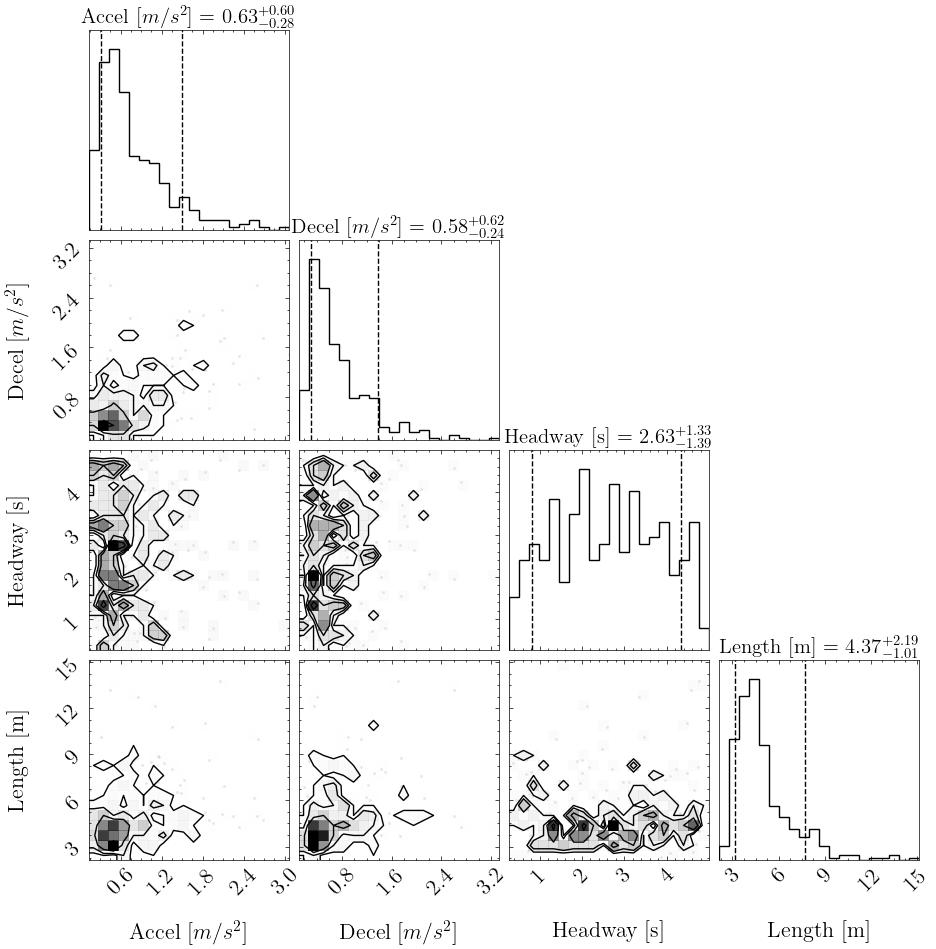

In [59]:
fig = corner.corner(
    corr_pwlf_df[["accel", "decel", "tau", "length"]],  # [['accel', 'decel']],
    labels=["Accel [$m/s^2$]", "Decel [$m/s^2$]", "Headway [s]", "Length [m]"],
    quantiles=(0.1, 0.9),
    show_titles=True,
    title_kwargs={"fontsize": 15},
)

# mean = accel_decel_df[['accel', 'decel']].mean()

# corner.overplot_lines(fig, mean, )

# # set the axis limits
# for ax in fig.axes:
#     ax.set_xlim(0, 4)


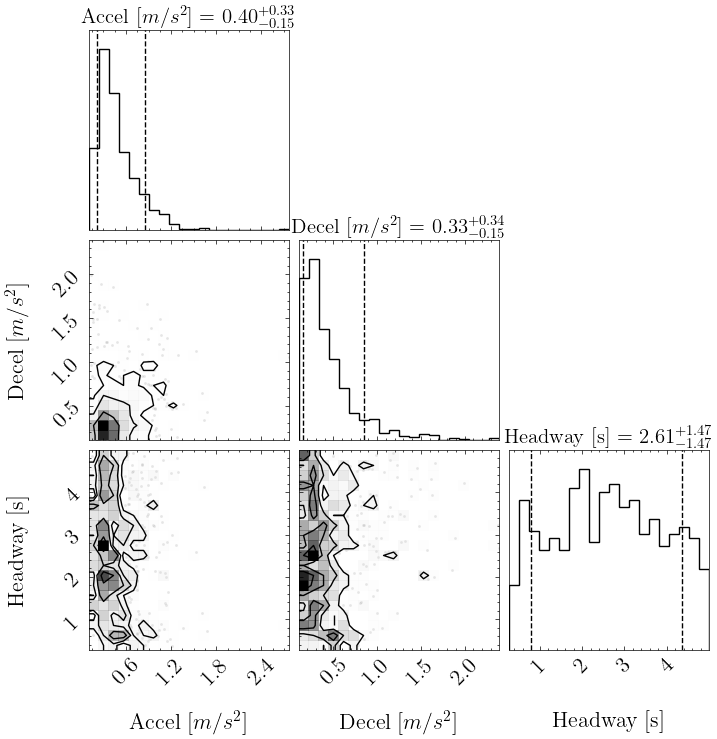

In [173]:
fig = corner.corner(
    corr_lowess_df,  # [['accel', 'decel']],
    labels=["Accel [$m/s^2$]", "Decel [$m/s^2$]", "Headway [s]"],
    quantiles=(0.1, 0.9),
    show_titles=True,
    title_kwargs={"fontsize": 15},
)


### Create a where a row represents a vehicle and the columns are accel and decel


In [5]:
keep_vehicles = types_df.loc[
    (types_df["type_accel"] > 0) & (types_df["type_decel"] > 0)
].index


In [6]:
both_vehicles = accel_deccel_df.loc[accel_deccel_df.vehicle_id.isin(keep_vehicles)]


In [7]:
groups = []
for name, group in both_vehicles[["vehicle_id", "type", "slope"]].groupby(
    ["vehicle_id"]
):
    # group[['type', 'slope']]
    accels = group.loc[group.type == "accel", "slope"].values
    decels = group.loc[group.type == "decel", "slope"].values
    # create combinations of accel and decel
    groups.extend(
        ({"id": name, "accel": accel, "decel": decel})
        for decel in decels
        for accel in accels
    )


/var/folders/96/_9h8bqbx4gqcmb4td8q57q8w0000gn/T/ipykernel_22692/388982627.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in both_vehicles[['vehicle_id', 'type', 'slope']].groupby(['vehicle_id']):


In [8]:
accel_decel_df = pd.DataFrame(groups)


In [9]:
accel_decel_df.head()


,id,accel,decel
0,55583,0.786503,-1.706129
1,55587,1.674436,-0.988193
2,55587,1.674436,-1.784263
3,55596,1.383191,-1.004798
4,55596,1.383191,-1.669873


### Clean it up and get it ready for SUMO


In [10]:
accel_decel_df["decel"] = accel_decel_df["decel"].abs()
accel_decel_df.drop("id", axis=1, inplace=True)


### Add the Vehicle Type


In [11]:
accel_decel_df[
    "vClass"
] = "passenger"  # np.random.choice(['passenger', 'trailer'], N, p=[0.8, 0.2])
accel_decel_df["emissionClass"] = accel_decel_df["vClass"].map(
    {"passenger": "PHEMlight/PC_G_EU4", "trailer": "PHEMlight/HDV_TT_D_EU6"}
)


## Add the Speed


In [12]:
import sumolib


In [13]:
net = sumolib.net.readNet(ROOT / "sumo-xml" / "net" / "simplified_reworked.net.xml")


In [14]:
e = net.getEdge("gneE11")
edgeSpeed = e.getSpeed()


In [15]:
cruise_df = df.loc[
    (df["type"] == "cruise") & (df["speed"] > 17) & (df["rmse"] < 0.05)
].copy()


In [16]:
sf_table = cruise_df["speed"] / edgeSpeed


In [17]:
accel_decel_df["speedFactor"] = sf_table.sample(
    accel_decel_df.shape[0], replace=True
).values


In [18]:
accel_decel_df.to_csv(
    ROOT / "data" / "rw_east_thru_summary_accel_decel.csv", index=False
)


<AxesSubplot: >

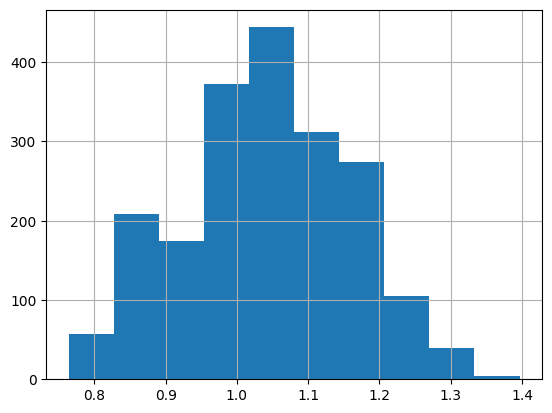

In [19]:
accel_decel_df["speedFactor"].hist()


In [49]:
# reduce the number of decimal places
print(accel_decel_df[["accel", "decel"]].corr().style.format("{:.2f}").to_latex())


NameError: name 'accel_decel_df' is not defined